In [1]:
import sys
sys.path.append('../')
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
from smodels.theory.element import Element
from smodels.particlesLoader import BSMList
from smodels.share.models.SMparticles import SMList
from smodels.theory.model import Model
from smodels.theory.graphTools import getTreeRoot,ParticleNode,drawTree
import itertools


In [2]:
slhafile = '../inputFiles/slha/lightEWinos.slha'
model = Model(inputFile=slhafile, BSMparticles=BSMList, SMparticles=SMList)
model.updateParticles(erasePrompt=['spin'])

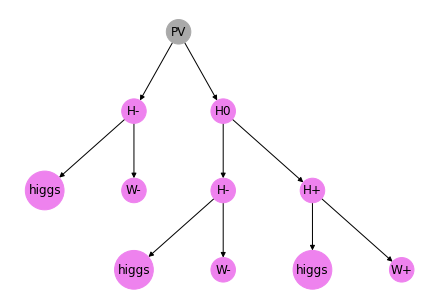

In [3]:
stringEla = "(PV > H0(1),H-(2)), (H0(1) > H+(3),H-(4)), (H+(3) > W+,higgs), (H-(4) > W-,higgs), (H-(2) > W-,higgs)"
ela = Element(info=stringEla,model=model)
ela.drawTree(nodeScale=3)

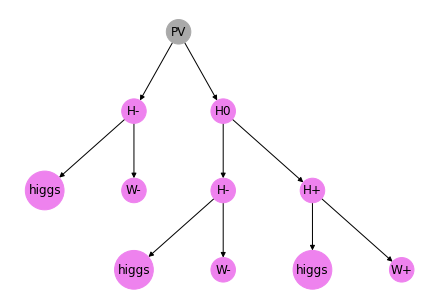

In [4]:
stringElb = "(PV > H0(1),H-(2)), (H-(2) > W-,higgs), (H0(1) > H-(3),H+(4)), (H-(3) > higgs,W-), (H+(4) > W+,higgs)"
elb = Element(info=stringElb,model=model)
elb.drawTree(nodeScale=3)

In [25]:
def compareNodes(treeA,treeB,nodeA,nodeB):
    
        if not isinstance(nodeA, ParticleNode):
            return -1,None
        if not isinstance(nodeB, ParticleNode):
            return -1,None

        if nodeA.canonName != nodeB.canonName:
            if nodeA.canonName > nodeB.canonName:
                return 1,None
            else:
                return -1,None
    #     print('\n\nComparing %s with %s' %(nodeA.particle,nodeB.particle))
    #     print('\t %s = %s (%s)' %(nodeA.particle,nodeB.particle,nodeA.particle == nodeB.particle))
        if nodeA.particle != nodeB.particle:
            if nodeA.particle > nodeB.particle:
                return 1,None
            else:
                return -1,None


        daugthersA = list(treeA.successors(nodeA))
        daugthersB = list(treeB.successors(nodeB))
        if not daugthersA and not daugthersB:
            newNodeB = nx.DiGraph()
            newNodeB.add_node(nodeB)
            return 0,newNodeB

    #     print('daughters A =',daugthersA)
    #     print('daughters B =',daugthersB)

        # Compute all permutations within each subgroup with a common canon name:
        allPerms = []
        for key,group in itertools.groupby(daugthersB,lambda d: d.canonName):
            allPerms.append(list(itertools.permutations(group)))

        # Construct all permutations and check against daughtersA:
        cmp = 0
        cmp_orig = None
        for dB_perm in itertools.product(*allPerms):
            dB_perm = list(itertools.chain.from_iterable(dB_perm))
    #         print('Checking permutation:',dB_perm)
            cmp = 0
            newDaughtersB = []
            for iB,dB in enumerate(dB_perm):
                cmp,newNodeB = eqNode(treeA,treeB,daugthersA[iB],dB)
                newDaughtersB.append(newNodeB)
                if cmp != 0: # If one node differs, try next permutation
                    break

            # The first permutation is the original ordering.
            # Store the comparison for the original ordering in case it does not match,
            # since this will be the value returned in this case.
            if cmp_orig is None:
                cmp_orig = cmp   

            if matches == 0: # If permutation matches, stop
                break

        # If matches also return a tree with the nodeB as root and its daughters
        # ordered according to how they matched nodeA
        if cmp == 0:
            newNodeB = nx.DiGraph()
            newNodeB.add_node(nodeB)
            for dB in newDaughtersB:
                dB.add_node(nodeB)
                dB.add_edge(nodeB,list(dB.nodes())[0])
                newNodeB = nx.compose(newNodeB,dB)
            return 0,newNodeB
        else:
            return cmp_orig,None

In [26]:
matches,newTree = eqNode(ela.tree,elb.tree,getTreeRoot(ela.tree),getTreeRoot(elb.tree))

In [27]:
print(matches)

True


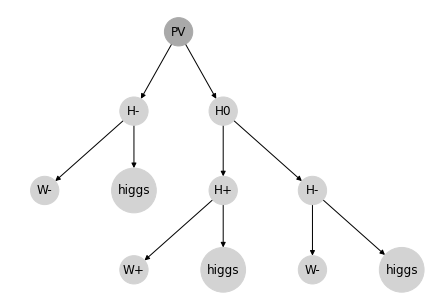

In [28]:
drawTree(newTree)

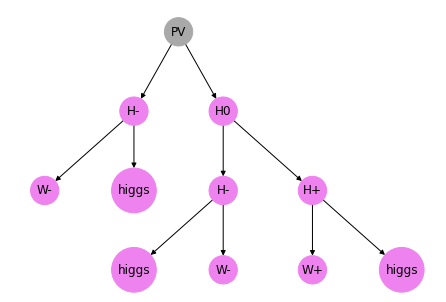

In [31]:
elb.drawTree()

In [34]:
x = [1,2,3,4]
for xx in itertools.permutations(x)[::-1]:
    print(xx)

TypeError: 'itertools.permutations' object is not subscriptable